# Cleaning Regression: Best Model

This notebook shows the optimal model for cleaning in the regression-based method.

In [15]:
# Importing some libraries

# Torch 
import torch
from torch import nn
import torch.nn.functional as F
from torchview import draw_graph

# Other libraries
import pickle
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import jaccard_score

**Unpacking the data**

In this first part, some functions are defined to unpack the data.

In [16]:
class CPU_Unpickler(pickle.Unpickler):
    # to avoid errors that occur when loading pickle files on cpu that were originally saved using a gpu
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)

In [17]:
# Function that enables you to unpack a certain chunk of data
def load_chunk_file(file_path, chunk_i):
    with open(file_path+f'chunk_{chunk_i}', 'rb') as file:
            loaded_data = CPU_Unpickler(file).load()
            
    return loaded_data

In [18]:
# The locations of the data
file_path_noisy = '/lustre/fs23/group/cta/users/amehta/summer_student_data/noisy_images/'
file_path_true = '/lustre/fs23/group/cta/users/amehta/summer_student_data/true_images/'

# Unpack 100 chunks of data
chunk_tot = 100

data_noisy_tot = np.array([])
data_true_tot = np.array([])

for chunk_i in range(0,chunk_tot):
    data_noisy_all = load_chunk_file(file_path_noisy, chunk_i)
    mask_gamma_ray = np.array((data_noisy_all[1]==1))
    data_noisy_chunk = np.array(data_noisy_all[0])[mask_gamma_ray]
    data_noisy_tot = np.append(data_noisy_tot, data_noisy_chunk)
    
    data_true_all = load_chunk_file(file_path_true, chunk_i)
    data_true_chunk = np.array(data_true_all[0])[mask_gamma_ray]
    data_true_tot = np.append(data_true_tot, data_true_chunk)
    
# Get it in the right shape
data_noisy = data_noisy_tot.reshape(64*chunk_tot, 56, 56)
data_true = data_true_tot.reshape(64*chunk_tot, 56, 56)


In [19]:
N_examples = len(data_noisy)
print(f"Number of images: {N_examples}")

Number of images: 6400


**Exploratory Data Analysis**

In this section, we have a look at some of the noisy and true data.

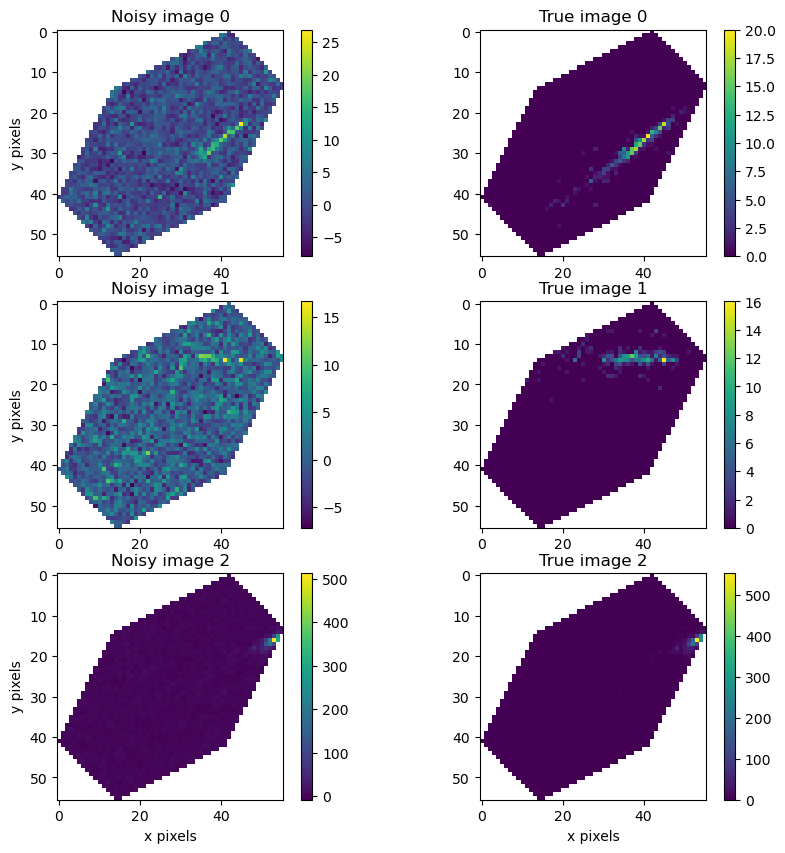

In [20]:
n_images = 3 # Compare 3 examples

fig, axs = plt.subplots(n_images, 2, figsize=(10,10))

for i in range(0,n_images):
    im_noisy = axs[i,0].imshow(data_noisy[i])
    axs[i,0].set_title(f"Noisy image {i}")
    axs[i,0].set_ylabel("y pixels")
    plt.colorbar(im_noisy, ax=axs[i,0])
    
    im_true = axs[i,1].imshow(data_true[i])
    axs[i,1].set_title(f"True image {i}")
    plt.colorbar(im_true, ax=axs[i,1])
    
    
axs[i,0].set_xlabel("x pixels")
axs[i,1].set_xlabel("x pixels")

plt.show()

**Data preperation**

In [21]:
# Now with a minimum of 0

nan_mask = np.isnan(data_noisy[0])
data_noisy_nonan = np.nan_to_num(data_noisy)
data_true_nonan = np.nan_to_num(data_true)

# Look at the sum of all the pixels for the noisy and true images

images_noisy_sum = np.nansum(data_noisy, axis=(1,2))
images_true_sum = np.nansum(data_true, axis=(1,2))

images_high_mask = (images_noisy_sum>60)

# Look at the true images only with pixels of 0 and 1 (non-signal and signal)
# For the purpose of the classification

threshold = 0

#data_true_binary = np.zeros((64*chunk_tot, 56, 56))
#data_true_binary[data_true>threshold] = 1
#data_true_binary_flat = data_true_binary.reshape((64*chunk_tot, 56*56))
data_true_nonan_flat = data_true_nonan.reshape((64*chunk_tot, 56*56))

# Putting them to the right form with normalization
data_noisy_arr = data_noisy[images_high_mask]
data_noisy_arr[np.nan_to_num(data_noisy_arr)<0] = 0


pix_max_noisy = np.nanmax(data_noisy_arr, axis=(1,2))[:, np.newaxis, np.newaxis]
data_noisy_norm = np.nan_to_num(data_noisy_arr/pix_max_noisy)
data_noisy_tensor = (torch.from_numpy(data_noisy_norm).float())

# Now normalize the true data in the same way as the noisy data

data_true_arr = data_true_nonan_flat[images_high_mask]
pix_max_true = np.nanmax(data_noisy_arr, axis=(1,2))[:, np.newaxis]
data_true_norm = np.nan_to_num(data_true_arr/pix_max_true)
data_true_tensor = (torch.from_numpy(data_true_norm).float())

data_noisy_tensor_im = (torch.from_numpy(data_noisy[images_high_mask])).float()

data_true_tensor_im = (torch.from_numpy(data_true[images_high_mask])).float()

# Split train and test

N, w, h = data_noisy_tensor.shape
idx_split = int(N*0.8) # 80% training, 20% testing
data_noisy_train = data_noisy_tensor[:idx_split]
data_true_train = data_true_tensor[:idx_split]
data_noisy_test = data_noisy_tensor[idx_split:]
data_true_test = data_true_tensor[idx_split:]

data_noisy_train_im = data_noisy_tensor_im[:idx_split]
data_true_train_im = data_true_tensor_im[:idx_split]
data_noisy_test_im = data_noisy_tensor_im[idx_split:]
data_true_test_im = data_true_tensor_im[idx_split:]



**The Autoencoder Model**

In [22]:
# AE with 4 layers

class AE4(nn.Module):
    def __init__(self):
        super().__init__()
        
        second_layer = 75
            
        # Encoder functions
        self.conv1a = nn.Conv2d(1, 10, kernel_size=(3,3), padding='same')
        self.conv1b = nn.Conv2d(10, 10, kernel_size=(3,3), padding='same')
        self.conv2a = nn.Conv2d(10, second_layer, kernel_size=(3,3), padding='same')
        self.conv2b = nn.Conv2d(second_layer, second_layer, kernel_size=(3,3), padding='same')
        
        # Decoder functions
        self.deconv1a = nn.ConvTranspose2d(second_layer, second_layer, kernel_size=(3,3), padding=1)
        self.deconv1b = nn.ConvTranspose2d(second_layer, 10, kernel_size=(3,3), padding=1)
        self.deconv2a = nn.ConvTranspose2d(10, 10, kernel_size=(3,3), padding=1)
        self.deconv2b = nn.ConvTranspose2d(10, 1, kernel_size=(3,3), padding=1)
        
    def forward(self, x):
        if x.dim() == 3:  # (C, H, W)
            x = x.unsqueeze(0)  # Convert to (N, C, H, W)
            
        N = (x.shape)[0]
        
        # Encoder part
        x = F.relu(self.conv1a(x))
        x = self.conv1b(x)
        x = F.relu(F.max_pool2d(x, (2,2)))
        x = F.relu(self.conv2a(x))
        x = self.conv2b(x)
        x = F.relu(F.max_pool2d(x, (2,2)))
        
        # Decoder part
        x = F.interpolate(x, scale_factor=(2,2), mode='nearest')
        x = F.relu(self.deconv1a(x))
        x = F.relu(self.deconv1b(x))
        x = F.interpolate(x, scale_factor=(2,2), mode='nearest')
        x = F.relu(self.deconv2a(x))
        x = self.deconv2b(x)
        
        # Get the right shape
        x = x.squeeze(0)
        
        if N==1:
            x = x.reshape(1, 56*56)
        else:
            x = x.reshape(batch_size, 56*56)
        
        return x         

In [23]:
# Functions and definitions for 
n_epochs = 50

train_counter = np.linspace(1, n_epochs, n_epochs)
test_counter = np.linspace(0, n_epochs, n_epochs+1)
train_losses = []
test_losses = []
IOU_list = []

batch_size=1
weight = 2

# This is the main training loop
def train(epoch):
    network.train()
    
    i=0
    train_loss = 0
    
    random_indices = torch.randperm(len(data_noisy_train))
    data_noisy_train_clone = torch.clone(data_noisy_train)
    data_true_train_clone = torch.clone(data_true_train)
    
    data_noisy_train[random_indices] = data_noisy_train_clone
    data_true_train[random_indices] = data_true_train_clone
    
    for noisy, true in zip(data_noisy_train, data_true_train):
        noisy = noisy.unsqueeze(0)
        true = true.unsqueeze(0)
        
        i=i+1
        optimizer.zero_grad()
        output = network(noisy)
        weights = torch.tensor([weight])
        loss = F.mse_loss(output, true)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*batch_size
    train_losses.append(train_loss/len(data_noisy_train))
    print('Training set: Avg. loss: {:.6f}'.format(train_loss/len(data_noisy_train)))

# This is the main testing loop
def test():
    network.eval()
    IOU = 0
    test_loss = 0
    correct = 0
    i=0
    with torch.no_grad():
        for noisy, true in zip(data_noisy_test, data_true_test):
            noisy = noisy.unsqueeze(0)
            true = true.unsqueeze(0)
            
            i=i+1
            output = network(noisy)
            weights = torch.tensor([weight])
            #print(output.shape)
            #print(true.shape)
            loss = F.mse_loss(output, true)
            test_loss += loss.item()
            #output_data = F.sigmoid(output.data)
            #output_binary = output_data.round()
    
    test_loss /= len(data_noisy_test)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.6f}'.format(test_loss))

**General run**

In [24]:
%%time

n_epochs = 50

learning_rate = 0.0001

network = AE4()
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)

train_counter = np.linspace(1, n_epochs, n_epochs)
test_counter = np.linspace(0, n_epochs, n_epochs+1)
train_losses = []
test_losses = []
IOU_list = []

test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()


Test set: Avg. loss: 0.239932
Training set: Avg. loss: 0.002292

Test set: Avg. loss: 0.000394
Training set: Avg. loss: 0.000365

Test set: Avg. loss: 0.000302
Training set: Avg. loss: 0.000307

Test set: Avg. loss: 0.000264
Training set: Avg. loss: 0.000276

Test set: Avg. loss: 0.000261
Training set: Avg. loss: 0.000255

Test set: Avg. loss: 0.000227
Training set: Avg. loss: 0.000238

Test set: Avg. loss: 0.000221
Training set: Avg. loss: 0.000225

Test set: Avg. loss: 0.000213
Training set: Avg. loss: 0.000215

Test set: Avg. loss: 0.000202
Training set: Avg. loss: 0.000208

Test set: Avg. loss: 0.000198
Training set: Avg. loss: 0.000201

Test set: Avg. loss: 0.000189
Training set: Avg. loss: 0.000197

Test set: Avg. loss: 0.000195
Training set: Avg. loss: 0.000191

Test set: Avg. loss: 0.000186
Training set: Avg. loss: 0.000186

Test set: Avg. loss: 0.000185
Training set: Avg. loss: 0.000183

Test set: Avg. loss: 0.000184
Training set: Avg. loss: 0.000179

Test set: Avg. loss: 0.0

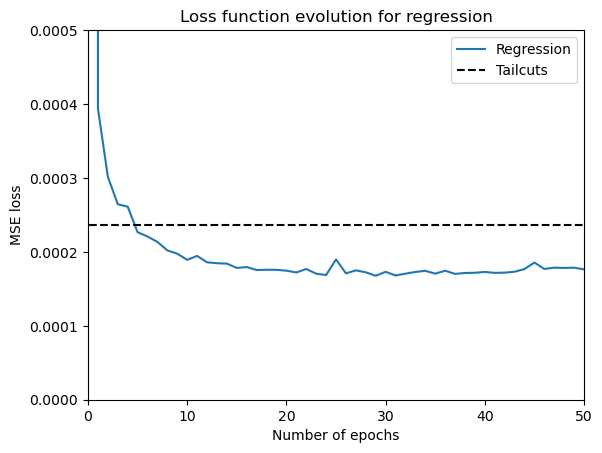

In [25]:
fig_reg=plt.figure()

plt.title("Loss function evolution for regression")
plt.plot(test_counter, test_losses, label='Regression')
plt.xlabel("Number of epochs")
plt.ylabel("MSE loss")
plt.xlim(0,50)
plt.ylim(0,0.0005)

# Only divided by pixmax
plt.hlines(0.00023664429947151884, -1, n_epochs+1, color='black', linestyles='--', label='Tailcuts')
plt.legend()

plt.show()


**Run with uncertainties**

In [26]:
%%time

n_runs = 5
MSE_all = []
n_epochs = 50

train_counter = np.linspace(1, n_epochs, n_epochs)
test_counter = np.linspace(0, n_epochs, n_epochs+1)

for i in range(0, n_runs):
    print()
    print(f"Run {i+1}")
    network = AE4()
    optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
    
    train_losses = []
    test_losses = []

    test()
    for epoch in range(1, n_epochs + 1):
        train(epoch)
        test()
    
    MSE_all.append(test_losses)
    
MSE_all_arr = np.array(MSE_all)


Run 1

Test set: Avg. loss: 0.026482
Training set: Avg. loss: 0.000624

Test set: Avg. loss: 0.000330
Training set: Avg. loss: 0.000300

Test set: Avg. loss: 0.000271
Training set: Avg. loss: 0.000258

Test set: Avg. loss: 0.000231
Training set: Avg. loss: 0.000236

Test set: Avg. loss: 0.000240
Training set: Avg. loss: 0.000223

Test set: Avg. loss: 0.000213
Training set: Avg. loss: 0.000212

Test set: Avg. loss: 0.000198
Training set: Avg. loss: 0.000203

Test set: Avg. loss: 0.000198
Training set: Avg. loss: 0.000197

Test set: Avg. loss: 0.000192
Training set: Avg. loss: 0.000191

Test set: Avg. loss: 0.000187
Training set: Avg. loss: 0.000187

Test set: Avg. loss: 0.000195
Training set: Avg. loss: 0.000182

Test set: Avg. loss: 0.000182
Training set: Avg. loss: 0.000178

Test set: Avg. loss: 0.000179
Training set: Avg. loss: 0.000174

Test set: Avg. loss: 0.000180
Training set: Avg. loss: 0.000172

Test set: Avg. loss: 0.000185
Training set: Avg. loss: 0.000168

Test set: Avg. lo

In [27]:
# Some operations to find the mean and the uncertainty bands

MSE_mean = np.mean(MSE_all_arr, axis=0)
MSE_std = np.std(MSE_all_arr, axis=0)

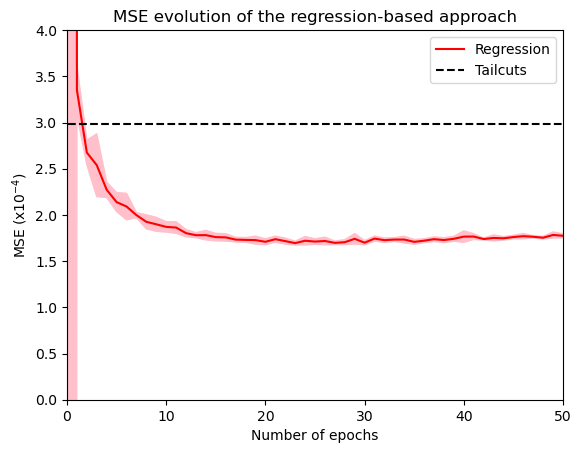

In [77]:
# Plot for presentation

fig_reg_pres=plt.figure()
plt.title("MSE evolution of the regression-based approach")
plt.plot(test_counter, 10**4*MSE_mean, color='red', label='Regression')
plt.fill_between(test_counter, 10**4*(MSE_mean-MSE_std), 10**4*(MSE_mean+MSE_std), color='pink')
plt.hlines(10**4*0.0002986057091539, -1, n_epochs+1, color='black', linestyles='--', label='Tailcuts')
plt.xlim(0,n_epochs)
plt.ylim(0,4)
plt.xlabel("Number of epochs")
plt.ylabel("$\mathrm{MSE \; (x 10^{-4})}$")
plt.legend()

plt.show()
fig_reg_pres.savefig("images/PerformanceRegPres.pdf")

In [39]:
data_true_tensor_unnorm = (torch.from_numpy(data_true_arr).float())
data_true_test_unnorm = data_true_tensor_unnorm[idx_split:]

In [50]:
# Calculate IoU

# Using the Jaccard score

IOU = 0
i=0
pixel_threshold = 0.8
IOU_list = []

for noisy, true in zip(data_noisy_test, data_true_test_unnorm):
    output = network(noisy.unsqueeze(0))
    clean_norm = output.data
    clean = clean_norm*pix_max_noisy[idx_split+i]
    
    clean_arr_iou = clean.detach().numpy()
    clean_binary = np.zeros(56*56)
    clean_binary[clean_arr_iou[0]>pixel_threshold] = 1
    
    
    true_arr_iou = true.detach().numpy()
    true_binary = np.zeros(56*56)
    true_binary[true_arr_iou>0.000] = 1 
    
    iou = jaccard_score(clean_binary, true_binary)
    IOU += iou
    IOU_list.append(iou)
    
    i=i+1
    
IOU = IOU/len(data_noisy_test)
    
print(f'IOU of regression model: {IOU}')

IOU_arr = np.array(IOU_list)

IOU of regression model: 0.4572817880640695


In [53]:
np.save("data_output/IOU_reg_dis.npy", IOU_arr)

In [55]:
pix_max_test = pix_max_noisy[idx_split:]

In [56]:
# Now calculate the MSE

MSE_list = []
MSE = 0
data_true_test_con = data_true[images_high_mask][idx_split:]
i=0

for noisy, true, pixmax in zip(data_noisy_test, data_true_test, pix_max_test):
    noisy = noisy.unsqueeze(0)
    true = true.unsqueeze(0)
            
    i=i+1
    output = network(noisy)
    loss = F.mse_loss(output, true)
    MSE += loss.item()
    MSE_list.append(loss.item())
    
    
MSE = MSE/len(data_noisy_test)
    
print(f'Normalized MSE of regression: {MSE}')

MSE_arr = np.array(MSE_list)

Normalized MSE of regression: 0.00017551233074704166


In [57]:
np.save("data_output/MSE_reg_dis.npy", MSE_arr)

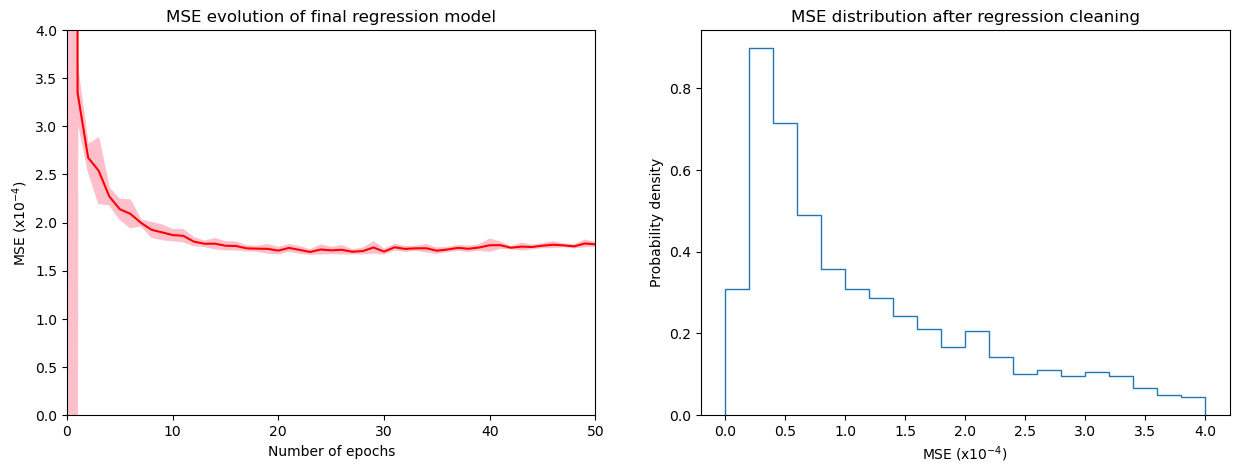

In [74]:
# Plot for report

fig_perf, axs = plt.subplots(1,2,figsize=(15,5))

axs[0].set_title("MSE evolution of final regression model")
axs[0].plot(test_counter, 10**4*MSE_mean, color='red')
axs[0].fill_between(test_counter, 10**4*(MSE_mean-MSE_std), 10**4*(MSE_mean+MSE_std), color='pink')
axs[0].set_xlim(0,n_epochs)
axs[0].set_ylim(0,4)
axs[0].set_xlabel("Number of epochs")
axs[0].set_ylabel("$\mathrm{MSE \; (x 10^{-4})}$")

axs[1].hist(MSE_arr*10**4, range=(0,4), bins=20, density=True, histtype='step')
axs[1].set_xlabel("$\mathrm{MSE \; (x 10^{-4})}$")
axs[1].set_ylabel("Probability density")
axs[1].set_title("MSE distribution after regression cleaning")

plt.show()
fig_perf.savefig("images/FinalPerformanceReg.pdf")